In [11]:
import re
import matplotlib.pyplot as plt
import string
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.tokenize.treebank import TreebankWordDetokenizer

from gensim.utils import simple_preprocess

import tensorflow as tf
import keras
from keras.layers.embeddings import Embedding

import os.path
from os import path

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alexandre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
device_lib.list_local_devices()

2022-01-27 15:09:35.354902: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 15:09:35.355398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 15:09:35.355653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.455GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2022-01-27 15:09:35.355696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library l

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12844010819053261269,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3302031360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14172493219326356338
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

# Load dataset & See stats

In [14]:
dataset = pd.read_csv("./data/raw/datasetBalanced.csv") \
            .drop_duplicates(subset='text', keep="last")[['text','sentiment']] # Remove duplicates & keep columns to use
        
dataset.head(5)

,text,sentiment
0,Our palace team will put our hearts out for ou...,1
1,Chelsea v Palace kick-off time changed and TV ...,1
2,Academy redevelopment update: Exclusive footag...,1
3,@ChelseaFC I still have no entire clue why us ...,1
4,"Pizza fight suggestions wrong, #CPFC wonderkid...",0


In [15]:
# Get the dataset lenght
len(dataset)

860452

In [16]:
# Validate if there are different values from negative (0), neutral (1) and positive (2)
dataset['sentiment'].unique()

array([1, 0, 2])

In [17]:
# How distributed is the dataset
dataset.groupby('sentiment').nunique()

,text
sentiment,
0,266239
1,309056
2,285157


# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [18]:
# Fill null values.
dataset["text"].fillna("No content", inplace=True)

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [19]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
TAG_RE = re.compile(r'<[^>]+>')
EMOJI_RE = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)

def depure_data(data):
    #Removing URLs with a regular expression
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

     #Remove @ sign
    data = re.sub("@[A-Za-z0-9]+","",data)

     #Remove http links
    data = re.sub(r"(?:@|http?://|https?://|www)\S+", "", data)

    #Remove Emojis
    data = EMOJI_RE.sub('', data)

    #Remove hashtag sign but keep the text
    data = re.sub("#[A-Za-z0-9]+","",data)

    # Remove html tags
    data = TAG_RE.sub('', data);

    return data

In [20]:
list_words = stopwords.words('english')

tweets = dataset['text'].values.tolist()
tweets_len = len(tweets)

remove_stopwords = lambda data: (" ").join([word for word in data.split() if not word in list_words]) # Remove unused words like will
processor = lambda sentence: simple_preprocess(str(sentence), deacc=True) # Lowecase, ponctuation & accents
detokenizer = lambda sequence: TreebankWordDetokenizer().detokenize(sequence) # Join sequence of tokens

data = list([detokenizer(processor(remove_stopwords(depure_data(tweets[i])))) for i in range(tweets_len)])

print(data[:5])

['our palace team put hearts fans don billions fans solid family fans', 'chelsea palace kick off time changed tv information confirmed', 'academy redevelopment update exclusive footage shows new site progression', 'still entire clue us crystal palace wouldn go abraham he top shout tbh he look striker maybe next transfer', 'pizza fight suggestions wrong wonderkid says interview national media']


In [21]:
data = np.array(data)

# Save cleaned data for performance purposes
pd.DataFrame(data).to_csv('./data/prepared/0_tweets.csv')

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [22]:
labels = tf.keras.utils.to_categorical(dataset['sentiment'], 3, dtype="float32")
print(labels)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

In [26]:
max_words = 5000
max_len = 200

In [27]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ... 1145  434   27]
 [   0    0    0 ...  723 1782  436]
 [   0    0    0 ...  894    9 1170]
 ...
 [   0    0    0 ...  193  286  150]
 [   0    0    0 ...  169  991  218]
 [   0    0    0 ...  994 2182  177]]


In [28]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, test_size=0.20, random_state=42)

print (len(X_train), len(X_test), len(y_train), len(y_test))

688361 172091 688361 172091


# Model building

Alright, in the next cells I'll guide you through the process of building 3 Recurrent Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer **LSTM** network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.

Let's get hands on:

## CNN layer model

In [36]:
from keras.models import Model
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input, Dropout
from keras.layers import GlobalMaxPooling1D
from keras import layers

model = Sequential()

model.add(layers.Embedding(max_words, 30))

model.add(Conv1D(60, 15, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("./models/0_cnn_tweet_sentiment.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=2, save_weights_only=False)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint1], batch_size=25)

Epoch 1/10
27535/27535 [==============================] - 120s 4ms/step - loss: 0.3239 - accuracy: 0.7962 - val_loss: 0.2504 - val_accuracy: 0.8527
Epoch 2/10
27535/27535 [==============================] - 112s 4ms/step - loss: 0.2545 - accuracy: 0.8518 - val_loss: 0.2428 - val_accuracy: 0.8589

Epoch 00002: val_accuracy improved from -inf to 0.85894, saving model to ./models/0_cnn_tweet_sentiment.hdf5
Epoch 3/10
27535/27535 [==============================] - 111s 4ms/step - loss: 0.2415 - accuracy: 0.8604 - val_loss: 0.2426 - val_accuracy: 0.8587
Epoch 4/10
27535/27535 [==============================] - 111s 4ms/step - loss: 0.2325 - accuracy: 0.8663 - val_loss: 0.2399 - val_accuracy: 0.8598

Epoch 00004: val_accuracy improved from 0.85894 to 0.85980, saving model to ./models/0_cnn_tweet_sentiment.hdf5
Epoch 5/10
27535/27535 [==============================] - 110s 4ms/step - loss: 0.2235 - accuracy: 0.8726 - val_loss: 0.2417 - val_accuracy: 0.8601
Epoch 6/10
27535/27535 [=============

# Best model validation


In [37]:
# Load the best model obtained during training
model = keras.models.load_model("./models/0_cnn_tweet_sentiment.hdf5")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('Model accuracy: ',test_acc)

5378/5378 - 11s - loss: 0.2399 - accuracy: 0.8598
Model accuracy:  0.859795093536377


In [38]:
predictions = model.predict(X_test)

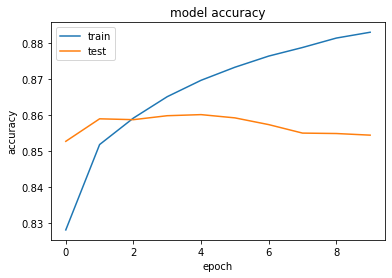

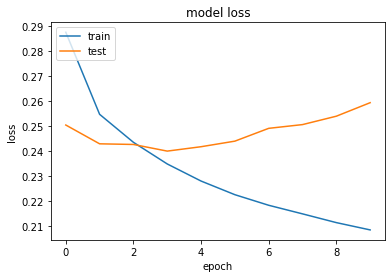

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Examples


In [40]:
sentiment = ['Negative', 'Neutral','Positive']

In [42]:
sequence = tokenizer.texts_to_sequences(['this experience has been the best, want my money back'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [59]:
sequence = tokenizer.texts_to_sequences(['never always good'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [60]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are fantastic'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [62]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'